Map:   0%|          | 0/2112 [00:00<?, ? examples/s]

Trainer is attempting to log a value of "[0.63380282 0.76923077 0.47619048 0.68987342 0.5        0.82389937
 0.91752577 0.61061947 0.8241206  0.64285714 0.45454545 0.4       ]" of type <class 'numpy.ndarray'> for key "eval/precision_per_class" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8490566  0.3125     0.47619048 0.61235955 0.30434783 0.74431818
 0.87567084 0.78409091 0.95626822 0.5625     0.625      0.5       ]" of type <class 'numpy.ndarray'> for key "eval/recall_per_class" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.72580645 0.44444444 0.47619048 0.64880952 0.37837838 0.78208955
 0.89610984 0.68656716 0.88529015 0.6        0.52631579 0.44444444]" of type <class 'numpy.ndarray'> for key "eval/f1_per_class" as a scalar. This invocation of Tensorboard's writer.add_sca


Per-Class Evaluation Metrics for DistilBERT:
     Category  Precision   Recall  F1-Score  Accuracy
National News   0.917526 0.875671  0.896110  0.875671
       Sports   0.824121 0.956268  0.885290  0.956268
Entertainment   0.823899 0.744318  0.782090  0.744318
         Bank   0.633803 0.849057  0.725806  0.849057
      Opinion   0.610619 0.784091  0.686567  0.784091
      Economy   0.689873 0.612360  0.648810  0.612360
   Technology   0.642857 0.562500  0.600000  0.562500
      Tourism   0.454545 0.625000  0.526316  0.625000
     Business   0.476190 0.476190  0.476190  0.476190
         Blog   0.769231 0.312500  0.444444  0.312500
        World   0.400000 0.500000  0.444444  0.500000
   Employment   0.500000 0.304348  0.378378  0.304348


<Figure size 1400x600 with 0 Axes>

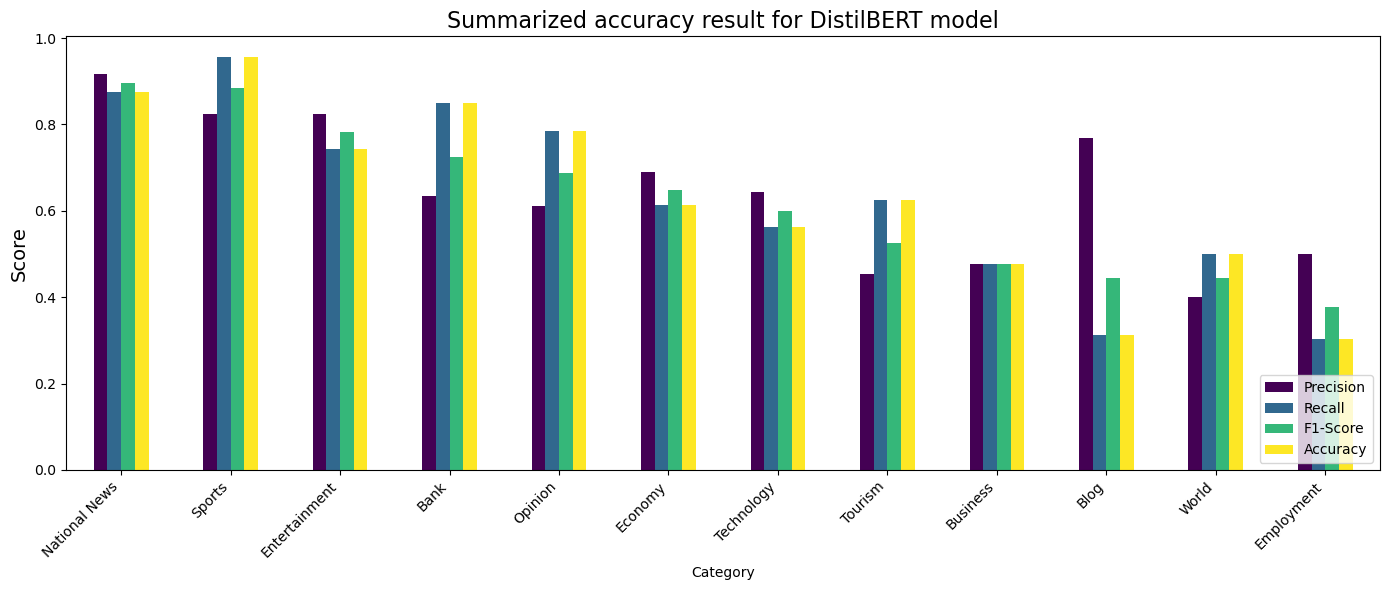


Per-Class Accuracy:
Bank: 0.8491
Blog: 0.3125
Business: 0.4762
Economy: 0.6124
Employment: 0.3043
Entertainment: 0.7443
National News: 0.8757
Opinion: 0.7841
Sports: 0.9563
Technology: 0.5625
Tourism: 0.6250
World: 0.5000

Overall Accuracy: 0.8205

Weighted Metrics:
Weighted Precision: 0.8273
Weighted Recall: 0.8205
Weighted F1-Score: 0.8197


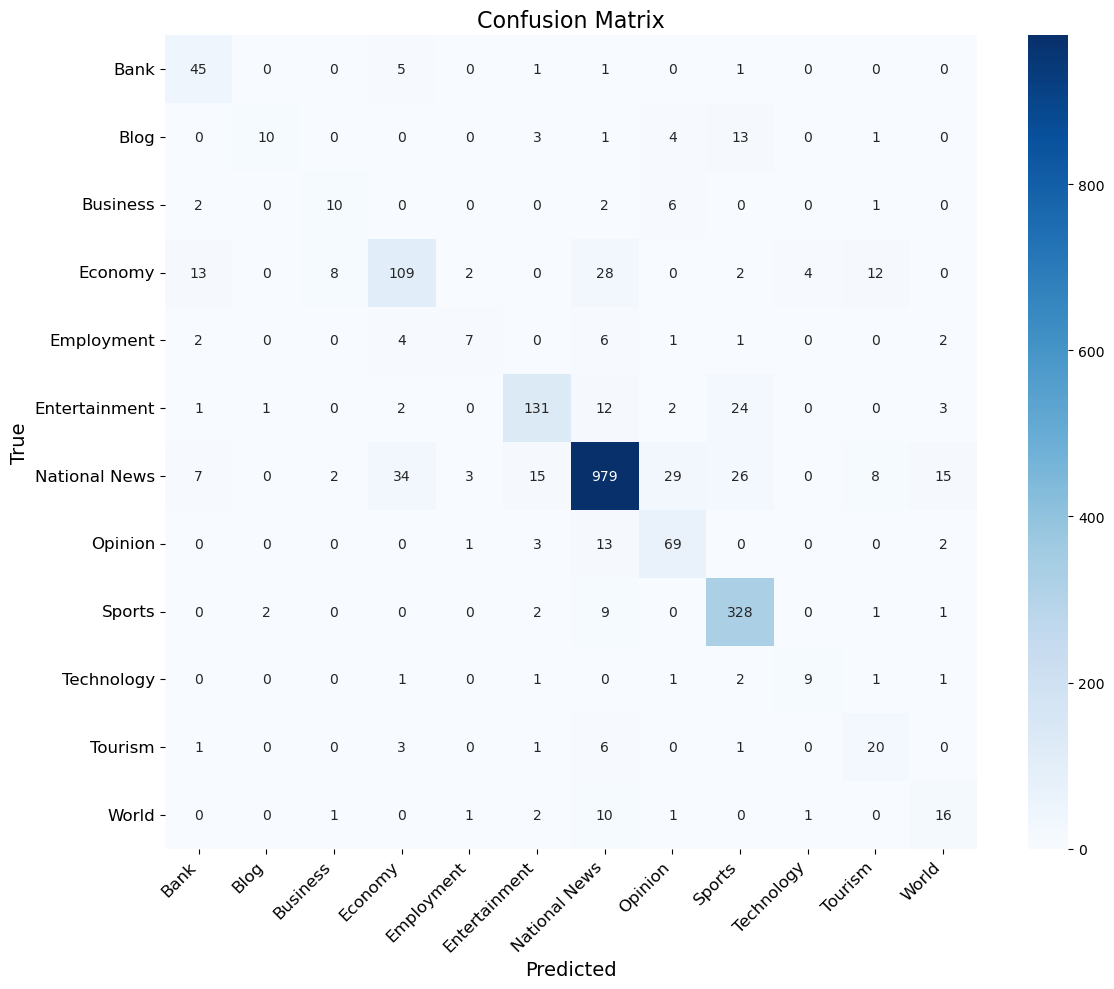

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import json
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# # News Classification Using BERT
# fine_model_name = "./nepali_news_mbert_fine_tuned_model/checkpoint-2958"
# model_tokenizer = "bert-base-multilingual-uncased"
# model_name = "BERT"

# # News Classification Using RoBERTa
# fine_model_name = "./nepali_news_xmlrobert_fine_tuned_model3e5"
# model_tokenizer = "xlm-roberta-base"
# model_name = "RoBERTa"

# News Classification Using DistilBERT
fine_model_name = "./nepali_news_distillbert_fine_tuned_model/checkpoint-2958"
model_tokenizer = "distilbert-base-multilingual-cased"
model_name = "DistilBERT"

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(fine_model_name, num_labels=12)
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

# Load the test data from CSV
test_df = pd.read_csv('3_split_data/test.csv')
test_df = test_df.dropna(subset=['content'])
test_df = test_df[test_df['content'].apply(lambda x: isinstance(x, str))]
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    cleaned_content = [str(content) if isinstance(content, str) else "" for content in examples['content']]
    return tokenizer(cleaned_content, padding="max_length", truncation=True)

test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load and invert label mapping
label_mapping_path = '1_combined_dataset/label_mapping.json'
with open(label_mapping_path, 'r') as json_file:
    label_mapping = json.load(json_file)

class_names = [None] * 12
for class_name, idx in label_mapping.items():
    class_names[idx] = class_name

def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'confusion_matrix': conf_matrix
    }

training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=10,
    eval_strategy="no",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

results = trainer.evaluate(eval_dataset=test_dataset)

# Compute per-class accuracy
conf_matrix = results['eval_confusion_matrix']
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Create a DataFrame without weighted metrics
eval_df = pd.DataFrame({
    'Category': class_names,
    'Precision': results['eval_precision_per_class'],
    'Recall': results['eval_recall_per_class'],
    'F1-Score': results['eval_f1_per_class'],
    'Accuracy': class_accuracy
})

# Sort by F1-score for better readability
eval_df = eval_df.sort_values(by='F1-Score', ascending=False)

# Print evaluation metrics
print(f"\nPer-Class Evaluation Metrics for {model_name}:")
print(eval_df.to_string(index=False))

# Visualize evaluation metrics without weighted summary
plt.figure(figsize=(14, 6))
eval_df.set_index('Category')[['Precision', 'Recall', 'F1-Score', 'Accuracy']].plot(kind='bar', figsize=(14, 6), colormap='viridis')
plt.title(f"Summarized accuracy result for {model_name} model", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f"images/evaluation_metrics_{model_name}.png", dpi=600, bbox_inches='tight')
plt.show()

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for class_idx, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracy[class_idx]:.4f}")
print(f"\nOverall Accuracy: {results['eval_accuracy']:.4f}")

# Print weighted metrics at last
print("\nWeighted Metrics:")
print(f"Weighted Precision: {results['eval_weighted_precision']:.4f}")
print(f"Weighted Recall: {results['eval_weighted_recall']:.4f}")
print(f"Weighted F1-Score: {results['eval_weighted_f1']:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig(f"images/confusion_matrix_{model_name}.png", dpi=600, bbox_inches='tight')
plt.show()
